c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


[[    3     3     1  7219    33]
 [    3     3     2  7378   102]
 [    3     3     3  8978    66]
 [    3     3     4  8105   116]
 [    3     3     5 11491    70]
 [    5     3     1 12349   214]
 [    5     3     2  8958   154]
 [    5     3     3 10661   156]
 [    5     3     4 11924   305]
 [    5     3     5  9848   417]
 [    7     3     1  8854   429]
 [    7     3     2 11098   886]
 [    7     3     3 12757   470]
 [    7     3     4 10233   594]
 [    7     3     5  8347   721]
 [   10     3     1  8347   721]
 [   10     3     2  8895   586]
 [   10     3     3  9554   999]
 [   10     3     4 11021   940]
 [   10     3     5  9416   917]]
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 694
    # data points      = 1
    # variables        = 3
    chi-square         = 1.1917e+09
    reduced chi-square = 1.1917e+09
    Akaike info crit   = 26.8986107
    Bayesian info crit = 20.8986107
##  Warning: uncertainties could not be estim

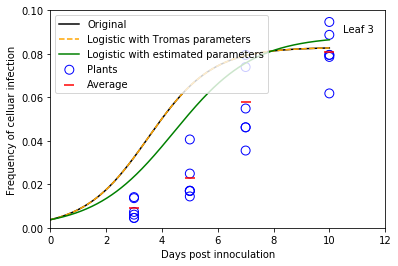

In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
import os
#==============================================================================
''' Make new data matrix for leaf 3 only '''
DataFrame = pd.read_csv('Cell_count_data_Tromas_2014.csv') # Read data from file

LEAF3_DATA = np.empty((round(DataFrame.shape[0] / 4), 5), int)
for i in range(round(DataFrame.shape[0] / 4)): # Number of rows
    for j in range(5):              # Number of columns desired
        LEAF3_DATA[i][j] = DataFrame.iloc[4 * i, j]
        if j == 4:
            LEAF3_DATA[i][j] = DataFrame.ix[4 * i, 'Venus_only'] + DataFrame.ix[4 * i, 'BFP_only'] + DataFrame.ix[4 * i, 'Mixed']
print(LEAF3_DATA)
'''
Col 0: Days post infection
Col 1: Leaf number
Col 2: Replicate plant number
Col 3: Number of unifected cells
Col 4: Number of total infected cells
'''
#==============================================================================
''' Create figure array '''
fig= plt.plot()
#==============================================================================
''' Make axis for data points '''
DAYS_AXIS = [3, 5, 7, 10]
#==============================================================================
''' Make axis for negative log likelihood '''
ZERO_DAYS_AXIS = [0, 3, 5, 7, 10]
#==============================================================================
''' Time axis for models '''
t = np.linspace(0, 10, 1000)
#==============================================================================
''' Initial condition '''
Ik0 = 3.72 * 10**-3
#==============================================================================
''' Parameter list (All initialized with guesses) '''
parameters = Parameters()
parameters.add('b', value = .871, min = .000000001, max = 1.0000)
parameters.add('psi3', value = .083, min = .000000001, max = 1.0000)
parameters.add('I0', value = 3.72 * 10**-3, min = .000000001, max = 1.0000)
#==============================================================================
''' Define the model, Eq. (1) on pg. 3 '''
def original(I3, t):
    b = .871
    psi3 = .083

    if (I3 < psi3):
        S3 = (1 - (I3 / psi3))

    dI3dt = b * I3 * S3

    return dI3dt
#==============================================================================
''' Define logistic model with Tromas' parameters '''
def tromas_log(L3, t):
    b = .871
    psi3 = .083

    dL3dt = b * L3 * (1 - (L3 / psi3))

    return dL3dt
#==============================================================================
''' Define logistic model '''
def model(M3, t, parameters):

    try: # Get parameters
        b    = parameters['b'].value
        psi3 = parameters['psi3'].value
    except KeyError:
        b, psi3 = parameters

    dM3dt = b * M3 * (1 - (M3 / psi3))

    return dM3dt
#==============================================================================
''' Compute negative log likelihood of Tromas' data given the model, see eq. (3) pg. 11 '''
def negLogLike(parameters):

    # Solve ODE system to get model values; parameters are not yet fitted
    M3 = odeint(model, parameters['I0'].value, ZERO_DAYS_AXIS, args=(parameters,))

    nll = 0;
    epsilon = 10**-10

    for t in range(4):     # Iterate through days
        for p in range(5): # Iterate through plants
            Vktp = LEAF3_DATA[5 * t + p][4]          # Number of infected cells
            Aktp = LEAF3_DATA[5 * t + p][3] + Vktp   # Total number of cells observed
            Iktp = M3[t + 1]                         # Frequency of cellular infection

            if (Iktp < epsilon):
                Iktp = epsilon

            if (Iktp > 1 - epsilon):
                Iktp = 1 - epsilon

            nll += Vktp * np.log(Iktp) + (Aktp - Vktp) * np.log(1 - Iktp)
    
    return -nll
#==============================================================================
''' Miminize negative log likelihood '''
result = minimize(negLogLike, parameters, method = 'differential_evolution')
#==============================================================================
''' Solve original differential equation '''
I3 = odeint(original, Ik0, t)
#==============================================================================
''' Solve logistic model with Tromas' parameters '''
L3 = odeint(tromas_log, Ik0, t)
#==============================================================================
''' Compare fitted values with those in Tromas' paper '''
print("======================================================================")
print("======================================================================")
report_fit(result)
print("======================================================================")
print("======================================================================")
print("Original beta = .871, My beta = ", result.params['b'].value)
print("Original psi3 = .083, My psi3 = ", result.params['psi3'].value)
print("Original I0 = .00372, My I0   = ", result.params['I0'].value)
#==============================================================================
''' Solve ODE system with fitted model parameters '''
M3 = odeint(model, Ik0, t, args=(result.params,))
#==============================================================================
''' Set up matricies '''
RATIOS = []
LEAF_DATA = np.empty((5, 4), float)  # Set up matrix
AVERAGES = []
#==========================================================================
for i in range(len(LEAF3_DATA)):  # Iterate through all rows
    non_infected = LEAF3_DATA[i][3]
    infected = LEAF3_DATA[i][4]
    ratio = infected / (non_infected + infected)
    RATIOS.append(ratio)
#==========================================================================
''' Build a matrix of ratios with each row being a replicate '''
for i in range(5):
    for j in range(4):
        LEAF_DATA[i][j] = RATIOS[i + 5 * j]
#==========================================================================
''' Calculate average cellular infection per day '''
for i in range(4):
    sum = 0
    for j in range(5):
        sum += LEAF_DATA[j][i]
        mean = sum / 5
    AVERAGES.append(mean)
#==============================================================================
''' Plot results '''
for i in range(5):
    plt.scatter(DAYS_AXIS, LEAF_DATA[i, :], s = 80, facecolors = 'none', edgecolors = 'b')
plt.scatter(DAYS_AXIS, LEAF_DATA[0, :], s = 80, facecolors = 'none', edgecolors = 'b', label = "Plants") # Plot copy to get one label
plt.scatter(DAYS_AXIS, AVERAGES, s = 120, color = 'r', marker = '_', label = "Average")

plt.plot(t, I3, color = 'black', label = "Original")
plt.plot(t, L3, color = 'orange', linestyle = 'dashed', label = "Logistic with Tromas parameters")
plt.plot(t, M3, color = 'green', label = "Logistic with estimated parameters")

plt.legend(loc = "upper left")
plt.xlim(0, 12)
plt.ylim(0, .10)
plt.xlabel('Days post innoculation')
plt.ylabel('Frequency of celluar infection')
plt.text(10.5, .09, 'Leaf 3')
#==============================================================================
plt.show()
plt.show()
#==============================================================================
''' Save figure '''
save_path = r'C:\Users\joshm\OneDrive\Documents\Plant_Gang' # Path to where you want the file to be saved
filename = "Leaf3Only.pdf" # Specify filename
#fig.savefig(os.path.join(save_path, filename)) # Save figure in the new directory